In [1]:
import numpy
import sys
# sys.path.append("/home/wian/Documents/BEng_Hons/Skogestad-Python/")
import utils
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting Singular Values Across Frequency

In [2]:
Kc = 1
def G(s):
    G11 = 4.29 * numpy.exp(-2.6 * s) / ((6.7 * s + 1))
    G12 = -2.38 * numpy.exp(-3.5 * s) / ((8.64 * s + 1))
    G13 = -2.156 * numpy.exp(-s) / ((9.06 * s + 1))
    G21 = 7.215 * numpy.exp(-6.5 * s) / ((3.25 * s + 1))
    G22 = -9.218 * numpy.exp(-3.0 * s) / ((5.0 * s + 1))
    G23 = -2.156 * numpy.exp(-s) / ((9.06 * s + 1))
    G31 = -0.5635 * numpy.exp(-9.2 * s) / ((8.15 * s + 1))
    G32 =  0.451143 * numpy.exp(-9.4 * s) / ((10.9 * s + 1))
    G33 = 1.1 * (10.1*s + 0.87) * numpy.exp(-s) / ((3.89 * s + 1)*(18.8*s + 1))
    return numpy.diag([Kc, Kc, Kc])*numpy.matrix([[G11, G12, G13],
                         [G21, G22, G23],
                         [G31, G32, G33]])

In [3]:
omega = numpy.logspace(-3,3,1000)

In [4]:
s = omega*1j

In [5]:
freq_responses = [G(si) for si in s]

In [6]:
def sigma(Gfr):
    return numpy.linalg.svd(Gfr)

In [7]:
sigmas = [sigma(G_fr)[1] for G_fr in freq_responses]
sigmas[0], sigmas[-1]

(array([12.90885196,  2.20755321,  0.55958636]),
 array([0.00293661, 0.00055712, 0.00014795]))

In [8]:
sigmas = numpy.array(sigmas)

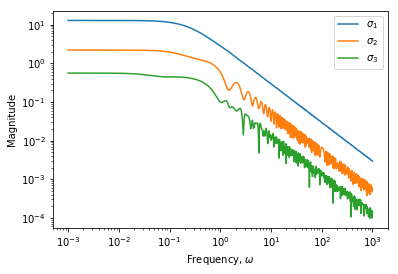

In [9]:
plt.loglog(omega, sigmas)
plt.ylabel('Magnitude')
plt.xlabel("Frequency, $\omega$")
plt.legend(["$\sigma_1$", "$\sigma_2$", "$\sigma_3$"])

# Analysing the input and output directions across frequency

In [10]:
def sinusoid(omega, r):
    gain = numpy.abs(r)
    phase = numpy.angle(r)
    return gain*numpy.sin(ts*omega + phase)

In [11]:
ts = numpy.linspace(0,10,1000)

In [12]:
def dirplot(omega_e, index):
    omega_c = 10**omega_e
    plt.subplot(3,1,1)
    plt.axvline(omega_c)
    plt.loglog(omega, sigmas)
    U, sigma, V = numpy.linalg.svd(G(omega_c*1j))
    V = V.H
    plt.subplot(3,1,2)
    plt.plot(ts, sinusoid(omega_c, V[0,index]))
    plt.plot(ts, sinusoid(omega_c, V[1,index]))
    plt.plot(ts, sinusoid(omega_c, V[2,index]))
    plt.subplot(3,1,3)
    plt.plot(ts, sigma[0]*sinusoid(omega_c, U[0,index]))
    plt.plot(ts, sigma[0]*sinusoid(omega_c, U[1,index]))
    plt.plot(ts, sigma[0]*sinusoid(omega_c, U[2,index]))

In [13]:
from ipywidgets import interact

In [14]:
interact(dirplot, omega_e = (0.0001, 2), index=[0,1])

interactive(children=(FloatSlider(value=1.00005, description='omega_e', max=2.0, min=0.0001), Dropdown(descrip…

<function __main__.dirplot(omega_e, index)>

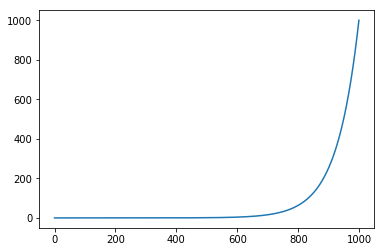

In [15]:
plt.plot(omega)

# Determining bandwidth and Plotting S($\sigma$)

In [16]:
Kc = 1
def S(s):
    return numpy.linalg.inv(numpy.eye(3) + numpy.diag([Kc, Kc, Kc])*G(s))

S(1)

matrix([[ 9.60244786e-01,  7.75167379e-03,  7.29728045e-02],
        [-2.65334347e-03,  1.08280306e+00,  8.14275233e-02],
        [ 5.72111834e-06, -3.20085968e-06,  9.56161077e-01]])

In [17]:
S_freq_responses = [S(si) for si in s]

In [18]:
S_sigmas = [sigma(G_fr)[1] for G_fr in S_freq_responses]

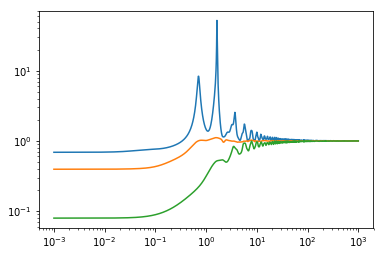

In [19]:
S_sigmas = numpy.array(S_sigmas)
plt.loglog(omega, S_sigmas)

In [20]:
Kc = 1
def T(s):
    return G(s)*numpy.linalg.inv(numpy.eye(3) + numpy.diag([Kc, Kc, Kc])*G(s))

In [21]:
T_freq_responses = [T(si) for si in s]

In [22]:
T_sigmas = [sigma(G_fr)[1] for G_fr in T_freq_responses]

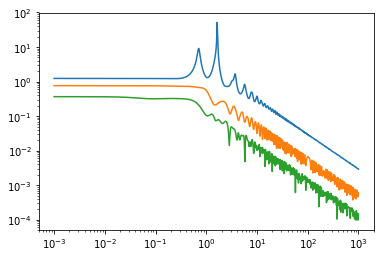

In [23]:
T_sigmas = numpy.array(T_sigmas)
plt.loglog(omega, T_sigmas)

In [24]:
omega_c = numpy.interp(1, T_sigmas[:,0][::-1], omega[::-1])
omega_c

2.0815692768013747

# Determining Bandwidth from Singular Values and Deadtime Constraints

In [25]:
Bandwidth = [0,0,0]

Bandwidth[0] = numpy.interp(1/numpy.sqrt(2), S_sigmas[:,0], omega)
Bandwidth[1] = numpy.interp(1/numpy.sqrt(2), S_sigmas[:,1], omega)
Bandwidth[2] = numpy.interp(1/numpy.sqrt(2), S_sigmas[:,2], omega)

Deadtimes = numpy.array([[2.6, 6.5, 9.2],
                          [3.5, 3.0, 9.4],
                          [1.0, 1.2, 1.0]])

DT_Bandwidths = 1/numpy.array([min(list(row)) for row in Deadtimes])

Bandwidth, DT_Bandwidths

([0.02381743746638373, 0.41721301559911883, 3.204142000548081],
 array([0.38461538, 0.33333333, 1.        ]))

In [26]:
utils.RGA(G(0))

array([[ 2.11123578, -0.84907281, -0.26216297],
       [-0.59035419,  1.67068873, -0.08033454],
       [-0.52088159,  0.17838408,  1.34249751]])

In [42]:
utils.RGA(G(10**(1)*1j))

array([[ 1.04590665, -0.27003426,  0.22412761],
       [-0.22061303,  1.24205703, -0.02144401],
       [ 0.17470638,  0.02797723,  0.7973164 ]])

In [128]:
omega_rga = numpy.logspace(-2, 1, 10000)
RGA_numbers = [utils.RGA(G(s)).diagonal() for s in omega_rga*1j]

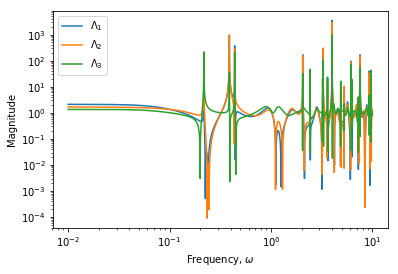

In [130]:
plt.loglog(omega_rga, numpy.abs(numpy.array(RGA_numbers)))
# plt.xlim([0.01, 3])
plt.xlabel("Frequency, $\omega$")
plt.ylabel("Magnitude")
plt.legend(["$\Lambda_1$", "$\Lambda_2$", "$\Lambda_3$"])

# Singular Value Directions

In [12]:
U, sigma, V = numpy.linalg.svd(G(0*1j))
U, sigma, V.H

(matrix([[-0.38647287+0.j,  0.88359766+0.j,  0.26437454+0.j],
         [-0.91962075+0.j, -0.39101549+0.j, -0.03747753+0.j],
         [ 0.07025949+0.j, -0.25760836+0.j,  0.96369162+0.j]]),
 array([12.90903513,  2.20758436,  0.55965665]),
 matrix([[-0.64548771-0.j,  0.50490461-0.j,  0.57307674-0.j],
         [ 0.73038507-0.j,  0.62747324-0.j,  0.26984249-0.j],
         [ 0.2233456 -0.j, -0.59274671-0.j,  0.77380106-0.j]]))

In [15]:
U, sigma, V = numpy.linalg.svd(G(1*1j))
numpy.abs(U), numpy.angle(U)*180/numpy.pi

(matrix([[0.16048767, 0.96091335, 0.22558644],
         [0.98699473, 0.15836703, 0.02759125],
         [0.00922508, 0.2270802 , 0.97383237]]),
 array([[ 152.23199216,  -74.32050096,  116.11584423],
        [ -86.40463901, -132.99214872,   58.33537228],
        [ -30.06056377,  100.77324878,  111.22720232]]))

In [16]:
sigma

array([2.83280575, 0.59298718, 0.09924362])

In [18]:
numpy.abs(V.H), numpy.angle(V.H)*180/numpy.pi

(matrix([[0.77241327, 0.58302136, 0.25192028],
         [0.63055041, 0.6584248 , 0.41095371],
         [0.07605203, 0.47598621, 0.87615822]]),
 array([[  -0.        , -180.        ,   -0.        ],
        [ -17.2465649 ,  -18.38611043,  166.98238032],
        [-134.34152092, -121.15702813, -117.67681508]]))